# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [126]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

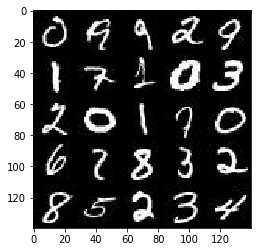

In [127]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

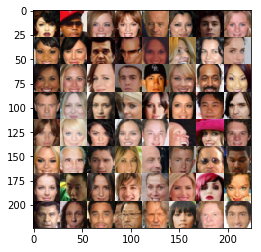

In [128]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [129]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [130]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return input_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [154]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        
        # 28 * 28 * 3
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same', kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        x1 = tf.maximum(0.2 * x1 , x1)
        x1 = tf.nn.dropout(x1, 0.5)
        
        # 14 * 14 
        x2 = tf.layers.conv2d(x1, 128, 5, strides = 2, padding = 'same', kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(0.2 * x2, x2)
        x2 = tf.nn.dropout(x2, 0.5)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides = 2, padding = 'same', kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(0.2 * x3, x3)
        x3 = tf.nn.dropout(x3, 0.5)
        
        
        x4 = tf.layers.conv2d(x3, 512, 5, strides = 2, padding = 'same', kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
        x4 = tf.layers.batch_normalization(x4, training = True)
        x4 = tf.maximum(0.2 * x4, x4)
        x4 = tf.nn.dropout(x4, 0.5)
        
        
        flat = tf.reshape(x3, (-1, 4096))
        dense = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(dense)
    
    return out, dense 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [145]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse = not is_train):
        x1= tf.layers.dense(z,  4*4*256)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training= is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        x1 = tf.nn.dropout(x1, 0.90)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=3, padding= 'same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        x2 = tf.nn.dropout(x2, 0.90)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding= 'same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        x3 = tf.nn.dropout(x3, 0.90)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding= 'valid')
        out = tf.nn.tanh(logits)
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [134]:
from random import randint

def label_smoothing(input):
    if input == 1:
        return randint(7, 12) / 10
    
    if input == 0:
        return randint(0, 3) / 10
    
    return input

# test:
print(label_smoothing(1))
print(label_smoothing(0))
    

1.1
0.1


In [135]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels=tf.ones_like(d_model_real))
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    #return d_loss, g_loss
    return (label_smoothing(d_loss), label_smoothing(g_loss))


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [136]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [137]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [138]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    step = 0
    show_every = 100
    print((data_shape[1], data_shape[2], data_shape[3]))
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                feed_dict = {input_real:batch_images, input_z:batch_z}
                _ = sess.run(d_opt, feed_dict=feed_dict)
                _ = sess.run(g_opt, feed_dict=feed_dict)
                
                _ = sess.run(g_opt, feed_dict = feed_dict) # as suggested by reviewer
                _ = sess.run(g_opt, feed_dict = feed_dict) # as suggested by reviewer
                
                if step % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                
                if step % show_every ==0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(28, 28, 1)
Epoch 1/2... Discriminator Loss: 1.1146... Generator Loss: 0.6200
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 0.6639
Epoch 1/2... Discriminator Loss: 1.0339... Generator Loss: 0.6756
Epoch 1/2... Discriminator Loss: 1.0291... Generator Loss: 0.6772
Epoch 1/2... Discriminator Loss: 1.0242... Generator Loss: 0.6833
Epoch 1/2... Discriminator Loss: 1.0190... Generator Loss: 0.6846
Epoch 1/2... Discriminator Loss: 1.0179... Generator Loss: 0.6847
Epoch 1/2... Discriminator Loss: 1.0133... Generator Loss: 0.6885
Epoch 1/2... Discriminator Loss: 1.0109... Generator Loss: 0.6903
Epoch 1/2... Discriminator Loss: 1.0129... Generator Loss: 0.6888


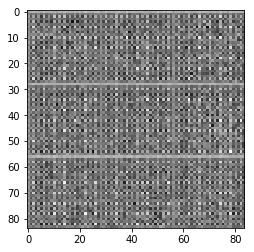

Epoch 1/2... Discriminator Loss: 1.0109... Generator Loss: 0.6904
Epoch 1/2... Discriminator Loss: 1.0109... Generator Loss: 0.6901
Epoch 1/2... Discriminator Loss: 1.0118... Generator Loss: 0.6894
Epoch 1/2... Discriminator Loss: 1.0100... Generator Loss: 0.6914
Epoch 1/2... Discriminator Loss: 1.0093... Generator Loss: 0.6916
Epoch 1/2... Discriminator Loss: 1.0094... Generator Loss: 0.6913
Epoch 1/2... Discriminator Loss: 1.0094... Generator Loss: 0.6909
Epoch 1/2... Discriminator Loss: 1.0096... Generator Loss: 0.6909
Epoch 1/2... Discriminator Loss: 1.0098... Generator Loss: 0.6912
Epoch 1/2... Discriminator Loss: 1.0110... Generator Loss: 0.6903


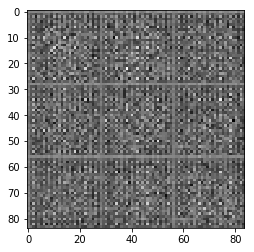

Epoch 1/2... Discriminator Loss: 1.0108... Generator Loss: 0.6901
Epoch 1/2... Discriminator Loss: 1.0122... Generator Loss: 0.6892
Epoch 1/2... Discriminator Loss: 1.0145... Generator Loss: 0.6872
Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 0.6891
Epoch 1/2... Discriminator Loss: 1.0172... Generator Loss: 0.6849
Epoch 1/2... Discriminator Loss: 1.0129... Generator Loss: 0.6897
Epoch 1/2... Discriminator Loss: 1.0125... Generator Loss: 0.6900
Epoch 1/2... Discriminator Loss: 1.0138... Generator Loss: 0.6887
Epoch 1/2... Discriminator Loss: 1.0207... Generator Loss: 0.6840
Epoch 1/2... Discriminator Loss: 1.0206... Generator Loss: 0.6839


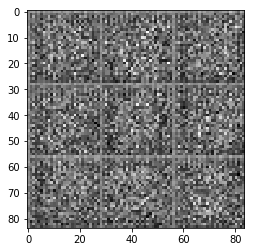

Epoch 1/2... Discriminator Loss: 1.0148... Generator Loss: 0.6877
Epoch 1/2... Discriminator Loss: 1.0193... Generator Loss: 0.6850
Epoch 1/2... Discriminator Loss: 1.0242... Generator Loss: 0.6812
Epoch 1/2... Discriminator Loss: 1.0212... Generator Loss: 0.6832
Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 0.6516
Epoch 1/2... Discriminator Loss: 1.0401... Generator Loss: 0.6765
Epoch 1/2... Discriminator Loss: 1.0189... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 1.0160... Generator Loss: 0.6889
Epoch 1/2... Discriminator Loss: 1.0439... Generator Loss: 0.6633
Epoch 1/2... Discriminator Loss: 1.0189... Generator Loss: 0.6868


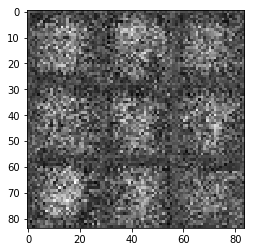

Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 0.6902
Epoch 1/2... Discriminator Loss: 1.0154... Generator Loss: 0.6886
Epoch 1/2... Discriminator Loss: 1.0151... Generator Loss: 0.6876
Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 0.6811
Epoch 1/2... Discriminator Loss: 1.0162... Generator Loss: 0.6874
Epoch 1/2... Discriminator Loss: 1.0139... Generator Loss: 0.6903
Epoch 1/2... Discriminator Loss: 1.0137... Generator Loss: 0.6897
Epoch 1/2... Discriminator Loss: 1.0102... Generator Loss: 0.6910
Epoch 1/2... Discriminator Loss: 1.0190... Generator Loss: 0.6841
Epoch 1/2... Discriminator Loss: 1.0232... Generator Loss: 0.6811


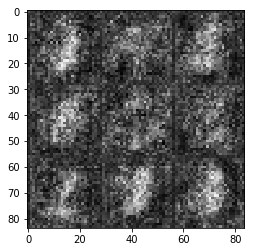

Epoch 1/2... Discriminator Loss: 1.0314... Generator Loss: 0.6738
Epoch 1/2... Discriminator Loss: 1.0172... Generator Loss: 0.6880
Epoch 1/2... Discriminator Loss: 1.0450... Generator Loss: 0.6631
Epoch 1/2... Discriminator Loss: 1.0217... Generator Loss: 0.6816
Epoch 1/2... Discriminator Loss: 1.0151... Generator Loss: 0.6877
Epoch 1/2... Discriminator Loss: 1.0117... Generator Loss: 0.6916
Epoch 1/2... Discriminator Loss: 1.0136... Generator Loss: 0.6881
Epoch 1/2... Discriminator Loss: 1.0137... Generator Loss: 0.6884
Epoch 1/2... Discriminator Loss: 1.0203... Generator Loss: 0.6845
Epoch 1/2... Discriminator Loss: 1.0124... Generator Loss: 0.6892


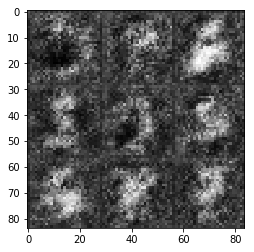

Epoch 1/2... Discriminator Loss: 1.0135... Generator Loss: 0.6885
Epoch 1/2... Discriminator Loss: 1.0160... Generator Loss: 0.6888
Epoch 1/2... Discriminator Loss: 1.0133... Generator Loss: 0.6891
Epoch 1/2... Discriminator Loss: 1.0111... Generator Loss: 0.6909
Epoch 1/2... Discriminator Loss: 1.0122... Generator Loss: 0.6891
Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 0.6806
Epoch 1/2... Discriminator Loss: 1.0106... Generator Loss: 0.6910
Epoch 1/2... Discriminator Loss: 1.0118... Generator Loss: 0.6897
Epoch 1/2... Discriminator Loss: 1.0118... Generator Loss: 0.6894
Epoch 1/2... Discriminator Loss: 1.0135... Generator Loss: 0.6901


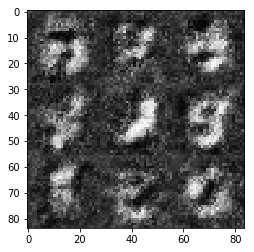

Epoch 1/2... Discriminator Loss: 1.0146... Generator Loss: 0.6909
Epoch 1/2... Discriminator Loss: 1.0227... Generator Loss: 0.6813
Epoch 1/2... Discriminator Loss: 1.0153... Generator Loss: 0.6881
Epoch 1/2... Discriminator Loss: 1.0221... Generator Loss: 0.6817
Epoch 1/2... Discriminator Loss: 1.0190... Generator Loss: 0.6840
Epoch 1/2... Discriminator Loss: 1.1791... Generator Loss: 0.5674
Epoch 1/2... Discriminator Loss: 1.0160... Generator Loss: 0.6888
Epoch 1/2... Discriminator Loss: 1.0254... Generator Loss: 0.6915
Epoch 1/2... Discriminator Loss: 1.0152... Generator Loss: 0.6878
Epoch 1/2... Discriminator Loss: 1.0202... Generator Loss: 0.6906


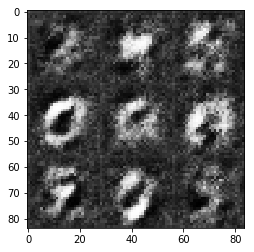

Epoch 1/2... Discriminator Loss: 1.0227... Generator Loss: 0.6808
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 0.6911
Epoch 1/2... Discriminator Loss: 1.0210... Generator Loss: 0.6831
Epoch 1/2... Discriminator Loss: 1.0361... Generator Loss: 0.6917
Epoch 1/2... Discriminator Loss: 1.0254... Generator Loss: 0.6813
Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 0.6723
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 0.6708
Epoch 1/2... Discriminator Loss: 1.0867... Generator Loss: 0.6928
Epoch 1/2... Discriminator Loss: 1.0187... Generator Loss: 0.6909
Epoch 1/2... Discriminator Loss: 1.0219... Generator Loss: 0.6833


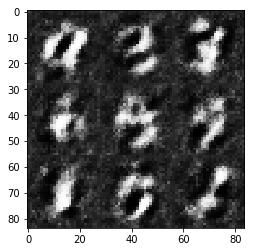

Epoch 1/2... Discriminator Loss: 1.0959... Generator Loss: 0.6262
Epoch 1/2... Discriminator Loss: 1.1670... Generator Loss: 0.5707
Epoch 1/2... Discriminator Loss: 1.0391... Generator Loss: 0.6919
Epoch 2/2... Discriminator Loss: 1.0244... Generator Loss: 0.6904
Epoch 2/2... Discriminator Loss: 1.0287... Generator Loss: 0.6800
Epoch 2/2... Discriminator Loss: 1.1258... Generator Loss: 0.6929
Epoch 2/2... Discriminator Loss: 1.0320... Generator Loss: 0.6899
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 0.6757
Epoch 2/2... Discriminator Loss: 1.0760... Generator Loss: 0.6439
Epoch 2/2... Discriminator Loss: 1.1143... Generator Loss: 0.6108


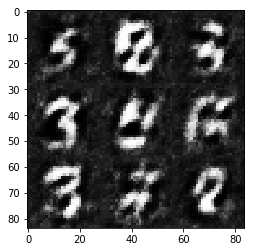

Epoch 2/2... Discriminator Loss: 1.0830... Generator Loss: 0.6384
Epoch 2/2... Discriminator Loss: 1.0518... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 1.0773... Generator Loss: 0.6436
Epoch 2/2... Discriminator Loss: 1.0607... Generator Loss: 0.6821
Epoch 2/2... Discriminator Loss: 1.0297... Generator Loss: 0.6853
Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 0.6729
Epoch 2/2... Discriminator Loss: 1.0596... Generator Loss: 0.6647
Epoch 2/2... Discriminator Loss: 1.0619... Generator Loss: 0.6691
Epoch 2/2... Discriminator Loss: 1.0303... Generator Loss: 0.6810


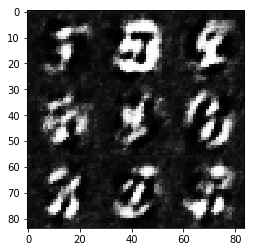

Epoch 2/2... Discriminator Loss: 1.0747... Generator Loss: 0.6459
Epoch 2/2... Discriminator Loss: 1.1806... Generator Loss: 0.5683
Epoch 2/2... Discriminator Loss: 1.0443... Generator Loss: 0.6809
Epoch 2/2... Discriminator Loss: 1.0827... Generator Loss: 0.6565
Epoch 2/2... Discriminator Loss: 1.0547... Generator Loss: 0.6891
Epoch 2/2... Discriminator Loss: 1.0750... Generator Loss: 0.6434
Epoch 2/2... Discriminator Loss: 1.1474... Generator Loss: 0.5840
Epoch 2/2... Discriminator Loss: 1.0712... Generator Loss: 0.6873
Epoch 2/2... Discriminator Loss: 1.0372... Generator Loss: 0.6825
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 0.6706


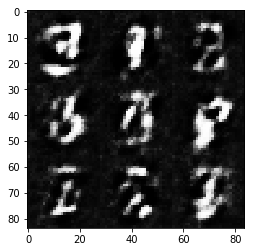

Epoch 2/2... Discriminator Loss: 1.0473... Generator Loss: 0.6648
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 0.6330
Epoch 2/2... Discriminator Loss: 1.1211... Generator Loss: 0.6036
Epoch 2/2... Discriminator Loss: 1.0541... Generator Loss: 0.6617
Epoch 2/2... Discriminator Loss: 1.0795... Generator Loss: 0.6425
Epoch 2/2... Discriminator Loss: 1.0849... Generator Loss: 0.6344
Epoch 2/2... Discriminator Loss: 1.1138... Generator Loss: 0.6877
Epoch 2/2... Discriminator Loss: 1.0398... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 1.0957... Generator Loss: 0.6718
Epoch 2/2... Discriminator Loss: 1.1060... Generator Loss: 0.6201


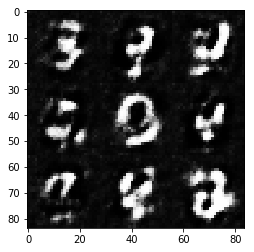

Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 0.6415
Epoch 2/2... Discriminator Loss: 1.0951... Generator Loss: 0.6374
Epoch 2/2... Discriminator Loss: 1.0638... Generator Loss: 0.6647
Epoch 2/2... Discriminator Loss: 1.1213... Generator Loss: 0.6117
Epoch 2/2... Discriminator Loss: 1.0524... Generator Loss: 0.6776
Epoch 2/2... Discriminator Loss: 1.0965... Generator Loss: 0.6321
Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 0.6000
Epoch 2/2... Discriminator Loss: 1.0523... Generator Loss: 0.6660
Epoch 2/2... Discriminator Loss: 1.0556... Generator Loss: 0.6608
Epoch 2/2... Discriminator Loss: 1.0410... Generator Loss: 0.6806


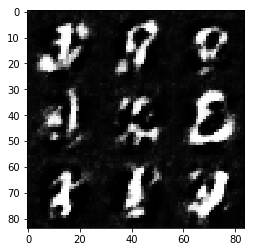

Epoch 2/2... Discriminator Loss: 1.0668... Generator Loss: 0.6849
Epoch 2/2... Discriminator Loss: 1.0538... Generator Loss: 0.6757
Epoch 2/2... Discriminator Loss: 1.0766... Generator Loss: 0.6506
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 0.6313
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 0.6484
Epoch 2/2... Discriminator Loss: 1.0376... Generator Loss: 0.6719
Epoch 2/2... Discriminator Loss: 1.0645... Generator Loss: 0.6510
Epoch 2/2... Discriminator Loss: 1.0456... Generator Loss: 0.6799
Epoch 2/2... Discriminator Loss: 1.0387... Generator Loss: 0.6780
Epoch 2/2... Discriminator Loss: 1.0680... Generator Loss: 0.6798


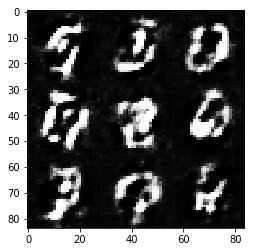

Epoch 2/2... Discriminator Loss: 1.0432... Generator Loss: 0.6675
Epoch 2/2... Discriminator Loss: 1.0911... Generator Loss: 0.6866
Epoch 2/2... Discriminator Loss: 1.0381... Generator Loss: 0.6740
Epoch 2/2... Discriminator Loss: 1.0569... Generator Loss: 0.6618
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 0.6726
Epoch 2/2... Discriminator Loss: 1.0953... Generator Loss: 0.6337
Epoch 2/2... Discriminator Loss: 1.0399... Generator Loss: 0.6778
Epoch 2/2... Discriminator Loss: 1.0628... Generator Loss: 0.6531
Epoch 2/2... Discriminator Loss: 1.0322... Generator Loss: 0.6897
Epoch 2/2... Discriminator Loss: 1.0323... Generator Loss: 0.6802


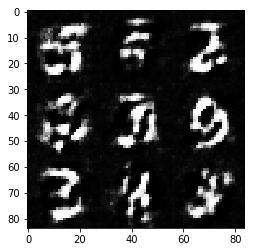

Epoch 2/2... Discriminator Loss: 1.0588... Generator Loss: 0.6725
Epoch 2/2... Discriminator Loss: 1.0362... Generator Loss: 0.6814
Epoch 2/2... Discriminator Loss: 1.0315... Generator Loss: 0.6785
Epoch 2/2... Discriminator Loss: 1.0409... Generator Loss: 0.6864
Epoch 2/2... Discriminator Loss: 1.0353... Generator Loss: 0.6737
Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 0.6792
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 0.6853
Epoch 2/2... Discriminator Loss: 1.0391... Generator Loss: 0.6790
Epoch 2/2... Discriminator Loss: 1.0422... Generator Loss: 0.6729
Epoch 2/2... Discriminator Loss: 1.0676... Generator Loss: 0.6431


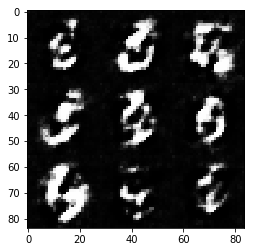

Epoch 2/2... Discriminator Loss: 1.0500... Generator Loss: 0.6603
Epoch 2/2... Discriminator Loss: 1.0323... Generator Loss: 0.6767
Epoch 2/2... Discriminator Loss: 1.0404... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 1.0425... Generator Loss: 0.6703
Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 0.6882
Epoch 2/2... Discriminator Loss: 1.0262... Generator Loss: 0.6827
Epoch 2/2... Discriminator Loss: 1.0364... Generator Loss: 0.6745
Epoch 2/2... Discriminator Loss: 1.0383... Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 1.0278... Generator Loss: 0.6822
Epoch 2/2... Discriminator Loss: 1.0358... Generator Loss: 0.6772


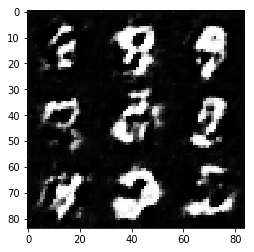

Epoch 2/2... Discriminator Loss: 1.0239... Generator Loss: 0.6795
Epoch 2/2... Discriminator Loss: 1.0732... Generator Loss: 0.6435
Epoch 2/2... Discriminator Loss: 1.0541... Generator Loss: 0.6579
Epoch 2/2... Discriminator Loss: 1.0470... Generator Loss: 0.6837
Epoch 2/2... Discriminator Loss: 1.0616... Generator Loss: 0.6520
Epoch 2/2... Discriminator Loss: 1.0256... Generator Loss: 0.6826
Epoch 2/2... Discriminator Loss: 1.1437... Generator Loss: 0.5886


In [36]:
batch_size = 64
z_dim = 100
learning_rate = 0.00001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(28, 28, 3)
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.6107
Epoch 1/1... Discriminator Loss: 1.7367... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.7709... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 1.8144
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 1.4765
Epoch 1/1... Discriminator Loss: 0.7515... Generator Loss: 2.0340
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 2.2253
Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 1.8006
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.8594


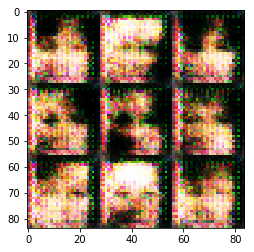

Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 1.7089
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 1.5168
Epoch 1/1... Discriminator Loss: 0.9218... Generator Loss: 1.4778
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.6101
Epoch 1/1... Discriminator Loss: 0.6020... Generator Loss: 2.7688
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.8657
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 2.0866
Epoch 1/1... Discriminator Loss: 0.7996... Generator Loss: 2.8780
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 1.9963
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 2.1569


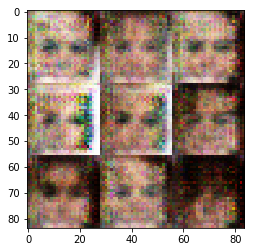

Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 1.5295
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 2.0941... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 1.5379
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 1.3208
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.9329
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 1.2624
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.7391


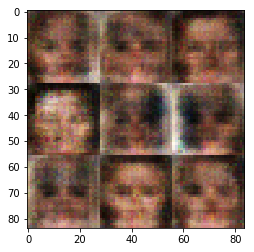

Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.5567... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 1.3390
Epoch 1/1... Discriminator Loss: 1.6575... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.8882... Generator Loss: 0.9134


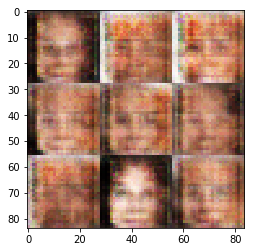

Epoch 1/1... Discriminator Loss: 1.8501... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 1.2914
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.7769... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7866


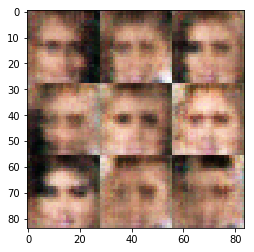

Epoch 1/1... Discriminator Loss: 1.6290... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.5716... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.5889... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 0.7204


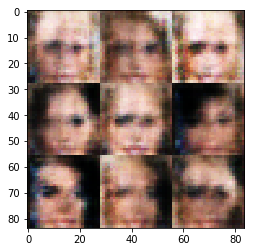

Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.5885... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.6086... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 1.0049


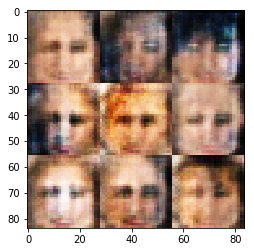

Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.5925... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.5564... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.6102... Generator Loss: 0.8384


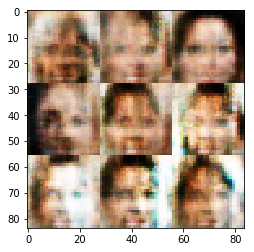

Epoch 1/1... Discriminator Loss: 1.5425... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.6312... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.8125


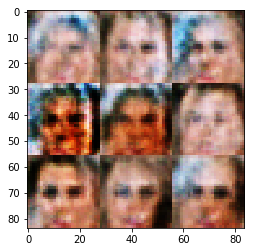

Epoch 1/1... Discriminator Loss: 1.6010... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.8062... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.9389


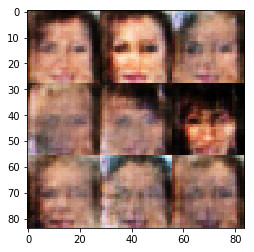

Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.6067... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.8715


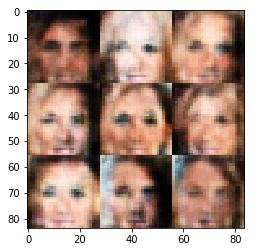

Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.7526... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.5864... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7445


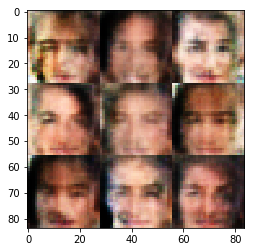

Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.6571... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.6107... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.6290... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.5506... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.5382... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.7397


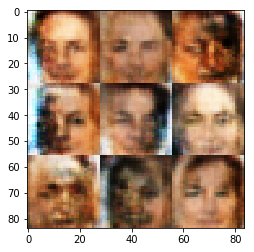

Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.5390... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.5578... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7778


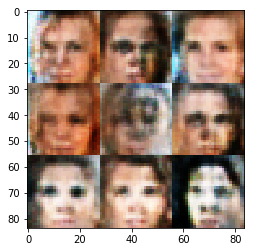

Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7120


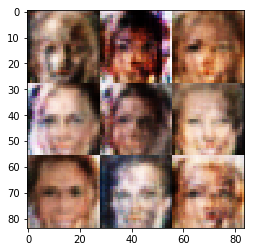

Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.6790


KeyboardInterrupt: 

In [153]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.